In [1]:
import pandas as pd
from time import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

**Objective:**

Predict customer churn using customer data indicating whether a customer left Telco in the last month.

Dataset: https://www.kaggle.com/blastchar/telco-customer-churn

The dataset includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(str(df.shape[0]) + ' rows | ' + str(df.shape[1]) + ' columns')

7043 rows | 21 columns


In [3]:
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [4]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

TotalCharges should be float.  But using the simple as_type(float) function isn't working.  Investigate manually:

In [5]:
count = 0
for v in df['TotalCharges'].values:
    try:
        float(v)
        count+= 1
    except:
        break
count

488

It's because some values in this column are read as ' '.  Create a function to fix this and turn the column into a float type for modeling:

In [6]:
def clean_total_charges(row):
    if row['TotalCharges'] == ' ':
        return 0.
    else:
        return float(row['TotalCharges'])
df['TotalCharges'] = df.apply(lambda row: clean_total_charges(row), axis = 1)

Examine unique values of each column:

In [7]:
for col in df.columns:
    print(col + ': ' + str(df[col].unique()))

customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)

Ensure that the customerID is unique:

In [8]:
len(df['customerID'].unique()) == len(df)

True

**EDA**

Briefly see if there is anything that can be discerned as driving customer churn.  We can potentially use this for feature selection and at least compare this against the models trained for classification.

Internet service:

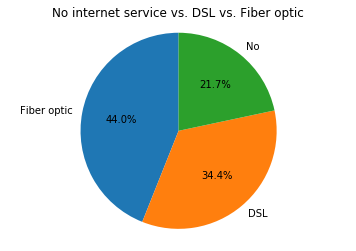

In [9]:
#overall distribution of No internet service vs. DSL vs. Fiber optic:

#https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
labels = df['InternetService'].value_counts().index
sizes = df['InternetService'].value_counts()
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels = labels, autopct = '%1.1f%%', startangle=90)
ax1.axis('equal')
plt.title('No internet service vs. DSL vs. Fiber optic')
plt.show()

Text(0.5,1,'Side-by-Side Histogram - Internet Services')

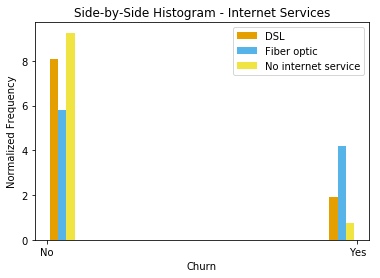

In [10]:
#https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0

x1 = list(df[df['InternetService'] == 'DSL']['Churn'])
x2 = list(df[df['InternetService'] == 'Fiber optic']['Churn'])
x3 = list(df[df['InternetService'] == 'No']['Churn'])

# Assign colors and the names
colors = ['#E69F00', '#56B4E9', '#F0E442']#, '#009E73', '#D55E00']
names = ['DSL', 'Fiber optic', 'No internet service']
         
# Make the histogram using a list of lists
# Normalize the frequencies and assign colors and names
plt.hist([x1, x2, x3], normed=True,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('Churn')
plt.ylabel('Normalized Frequency')
plt.title('Side-by-Side Histogram - Internet Services')

Less than 60% of Fiber Optic customers renew in the next month.  This may be because competitors are offering superior deals for this technology.  Interestingly, customers with no internet service have an extremely high retention rate, but these customers comprise just over a fifth of the customer base in this dataset.

DSL has about an 80% retention rate, probably because this is an older technology with less market competition.  Telco may be an established player in this particular market.  Moreover, customers with DSL are likely less likely to be seeking better offers, since this technology involves less functionality to begin with.

Phone service:

Text(0.5,1,'Side-by-Side Histogram - Phone Services')

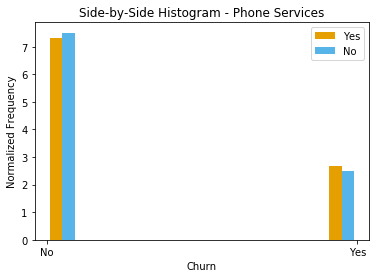

In [11]:
x1 = list(df[df['PhoneService'] == 'Yes']['Churn'])
x2 = list(df[df['PhoneService'] == 'No']['Churn'])

# Assign colors and the names
colors = ['#E69F00', '#56B4E9'] #'#F0E442']#, '#009E73', '#D55E00']
names = ['Yes', 'No']
         
# Make the histogram using a list of lists
# Normalize the frequencies and assign colors and names
plt.hist([x1, x2], normed=True,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('Churn')
plt.ylabel('Normalized Frequency')
plt.title('Side-by-Side Histogram - Phone Services')

The normalized frequencies are almost identical, so this isn't going to be a helpful predictor for our classifier.

Contract type is probably going to be a telling indicator, since this is directly related to bundles and pricing.  Let's take a look:

Text(0.5,1,'Side-by-Side Histogram - Contract Type')

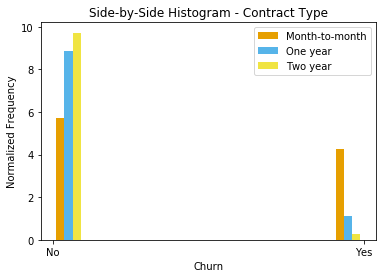

In [12]:
x1 = list(df[df['Contract'] == 'Month-to-month']['Churn'])
x2 = list(df[df['Contract'] == 'One year']['Churn'])
x3 = list(df[df['Contract'] == 'Two year']['Churn'])

# Assign colors and the names
colors = ['#E69F00', '#56B4E9', '#F0E442']#, '#009E73', '#D55E00']
names = ['Month-to-month', 'One year', 'Two year']
         
# Make the histogram using a list of lists
# Normalize the frequencies and assign colors and names
plt.hist([x1, x2, x3], normed=True,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('Churn')
plt.ylabel('Normalized Frequency')
plt.title('Side-by-Side Histogram - Contract Type')

While there are some significant disparities across contract types, I realized I cannot conclude anything due to the limitation of the dataset.  This data indicates whether a customer left within the last month. Indeed, many who have 1+ year contracts may not have the option to leave, even if they wanted to.

An additional aspect to explore is whether the customer has dependents - hypothesis here would be if a customer has children/dependents, they might have an increased amount of usage, and it could be that competitors can offer superior options:

Text(0.5,1,'Side-by-Side Histogram - Dependents')

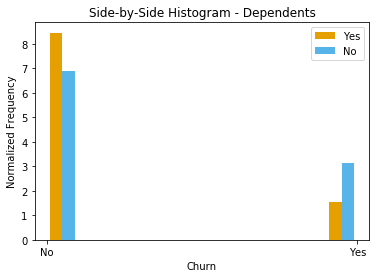

In [13]:
x1 = list(df[df['Dependents'] == 'Yes']['Churn'])
x2 = list(df[df['Dependents'] == 'No']['Churn'])

# Assign colors and the names
colors = ['#E69F00', '#56B4E9'] #'#F0E442']#, '#009E73', '#D55E00']
names = ['Yes', 'No']
         
# Make the histogram using a list of lists
# Normalize the frequencies and assign colors and names
plt.hist([x1, x2], normed=True,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('Churn')
plt.ylabel('Normalized Frequency')
plt.title('Side-by-Side Histogram - Dependents')

I don't see this as a material difference.  If anything, Telco is probably doing fine w/r/t this hypothesis since customers with dependents have a higher retention rate.

Could monthly charges be an indicator?  Let's look at some box plots for customers who left vs those who stayed:

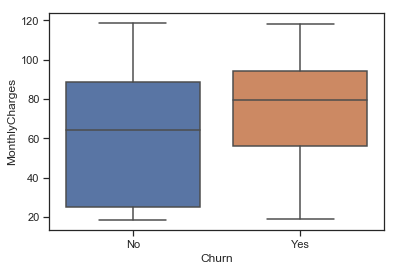

In [14]:
#https://stackoverflow.com/questions/37191983/python-side-by-side-box-plots-on-same-figure
sns.set(style = "ticks")
ax = sns.boxplot(x = 'Churn', y = 'MonthlyCharges', data = df)

This definitely makes sense... people who left tend to have higher monthly charges than those who stayed.  Assuming these are charges for the past month, perhaps total charges could give some context.  We will need to scale this by tenure (assuming tenure is number of months).

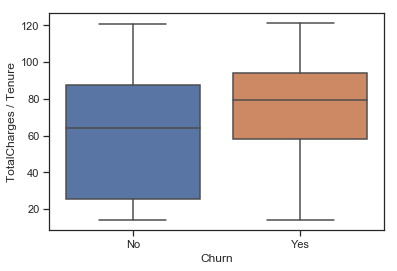

In [15]:
df['TotalCharges / Tenure'] = df['TotalCharges'] / df['tenure']

ax = sns.boxplot(x = 'Churn', y = 'TotalCharges / Tenure', data = df)

Seeing the same thing: the 25th percentile of customers who left is almost equal to the mean of those who stayed.

While there was no discernable difference in churn for those who used Telco's phone service vs. those who didn't, perhaps we can look at the tenure-adjusted total cost and see how the churn differs based on whether the users used phone service:

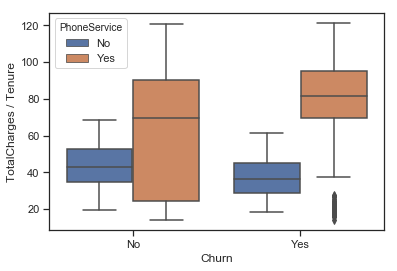

In [16]:
ax = sns.boxplot(x = 'Churn', y = 'TotalCharges / Tenure', hue = 'PhoneService', data = df)

In [23]:
df = df.drop('TotalCharges / Tenure', axis = 1)

Based on this box plot, it looks like users who used Telco's phone service and left had much higher monthly charges.  Let's look at how many of them also used some sort of internet service: 

In [24]:
len(df[df['InternetService'] != 'No']) / len(df) # 78% of users in the data had internet

0.7833309669175067

In [25]:
len(df[(df['InternetService'] != 'No') & (df['Churn'] == 'Yes')]) / len(df[df['Churn'] == 'Yes'])
#94% of users who left had internet

0.9395398608881755

In [26]:
len(df[(df['InternetService'] != 'No') 
       & (df['Churn'] == 'Yes') 
       & (df['PhoneService'] == 'Yes')]) / len(df[df['Churn'] == 'Yes'])
#85% of users who left had both internet and phone service

0.8485821294810059

Based on these proportions, it looks like there could be something with bundling that is driving customers to leave.  Customers who left who did not have phone services had much, much lower average monthly costs.  Customers who left and did most likely also had internet. I'm sure there are competitors that are offering better internet/phone service bundles.

Examine distribution of customers who churned:

In [27]:
df['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

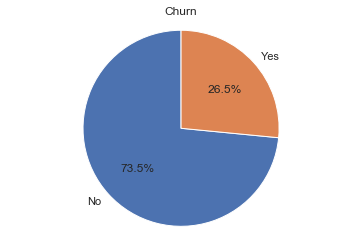

In [28]:
labels = df['Churn'].value_counts().index
sizes = df['Churn'].value_counts()
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels = labels, autopct = '%1.1f%%', startangle=90)
ax1.axis('equal')
plt.title('Churn')
plt.show()

**Modeling time**

I am going to use logistic regression and random forest for my classification models.

Logistic is helpful because it indicates the correlation between each variable and churn.  Random Forest tends to perform well overall and can accommodate categorical data.

Designate numeric vs. categorical columns for subsequent one-hot encoding:

In [29]:
cols_numeric = [
    'tenure', 
    'MonthlyCharges',
    'TotalCharges'   
]

cols_categorical = [col for col in df.columns if col not in cols_numeric and col not in ['customerID','Churn']]
cols_categorical

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [30]:
df2 = pd.get_dummies(df, columns = cols_categorical)
df2['Churn'] = df2['Churn'].map({'Yes': 1, 'No': 0})
df2.head()

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,1,29.85,29.85,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
1,5575-GNVDE,34,56.95,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,3668-QPYBK,2,53.85,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,7795-CFOCW,45,42.30,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,9237-HQITU,2,70.70,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


In [31]:
#Also want to drop rows where TotalCharges = 0, since this was previously blank (no values of 0 in original dataset):
df2 = df2[df2['TotalCharges'] != 0].reset_index(drop = True)

In [32]:
"""
recycling some code from one of my projects:
https://github.com/robdowns/Udacity-DSND-Term-1/blob/master/finding_donors.ipynb
"""

rf_results = {}
start = time()
    
#define the response
response = df2['Churn']
feature_cols = [col for col in df2.columns if col not in ['Churn','customerID']]
features = df2[feature_cols]


# Split the 'features' and response into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features,response,test_size = 0.2,random_state = 0)
    
print("Training Random Forest...")
    
rf = RandomForestClassifier(random_state = 7)
#fit the regressor
rf_fit = rf.fit(X_train, y_train)
#predict using the values using the training data and the fitted model
predictions_train = rf.predict(X_train)
    
#predict using the values using the testing data and the fitted model
predictions_test = rf.predict(X_test)
    
    
end = time()
runtime = end - start
    
    #store the results
rf_results = {
        'fitted model object': rf_fit,
#        'model iteration': 'prototype',
#        'y_train': y_train,
#        'y_test': y_test,
#        'predictions on training data': predictions_train,
#        'predictions on test data': predictions_test,
        'train accuracy': metrics.accuracy_score(y_train, predictions_train),
        'test accuracy': metrics.accuracy_score(y_test, predictions_test),
        'runtime': runtime
    }
print("Model trained; results stored.")

Training Random Forest...
Model trained; results stored.


In [34]:
rf_results

{'fitted model object': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=10,
                        n_jobs=None, oob_score=False, random_state=7, verbose=0,
                        warm_start=False),
 'train accuracy': 0.9816888888888889,
 'test accuracy': 0.7711442786069652,
 'runtime': 0.12900376319885254}

In [57]:
rf_results['fitted model object'].feature_importances_

array([0.12976759, 0.14076303, 0.16974638, 0.01603786, 0.01780028,
       0.0149354 , 0.01336701, 0.01179727, 0.01322644, 0.0145291 ,
       0.0124424 , 0.00294575, 0.00215214, 0.01277818, 0.00308814,
       0.01495985, 0.01324717, 0.01361587, 0.00141109, 0.03918834,
       0.00075715, 0.00750665, 0.01560718, 0.01160929, 0.01022548,
       0.01134925, 0.00037806, 0.01198226, 0.02791703, 0.00036123,
       0.00941001, 0.01050554, 0.00025697, 0.01295046, 0.01238771,
       0.00364771, 0.0115151 , 0.03384446, 0.01827364, 0.0286758 ,
       0.01478693, 0.01447553, 0.01120055, 0.0124192 , 0.04040509,
       0.00975244])

In [62]:
df_coefficients = pd.DataFrame(zip(features,
    rf_results['fitted model object'].feature_importances_.transpose()))
df_coefficients.columns = ['Feature', 'Importance']
df_coefficients = df_coefficients.sort_values(by = 'Importance', ascending = False)
df_coefficients

,Feature,Importance
2,TotalCharges,0.169746
1,MonthlyCharges,0.140763
0,tenure,0.129768
44,PaymentMethod_Electronic check,0.040405
19,OnlineSecurity_No,0.039188
37,Contract_Month-to-month,0.033844
39,Contract_Two year,0.028676
28,TechSupport_No,0.027917
38,Contract_One year,0.018274
4,gender_Male,0.017800


In [35]:
logit_results = {}
start = time()
    
print("Training logistic...")
    
logit = LogisticRegression(random_state = 7)
#fit the regressor
logit_fit = logit.fit(X_train, y_train)
#predict using the values using the training data and the fitted model
predictions_train = logit.predict(X_train)
    
#predict using the values using the testing data and the fitted model
predictions_test = logit.predict(X_test)
    
    
end = time()
runtime = end - start
    
    #store the results
logit_results = {
        'fitted model object': logit_fit,
#        'model iteration': 'prototype',
#        'y_train': y_train,
#        'y_test': y_test,
#        'predictions on training data': predictions_train,
#        'predictions on test data': predictions_test,
        'train accuracy': metrics.accuracy_score(y_train, predictions_train),
        'test accuracy': metrics.accuracy_score(y_test, predictions_test),
        'runtime': runtime
    }
print("Model trained; results stored.")

Training logistic...
Model trained; results stored.


In [36]:
logit_results

{'fitted model object': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=7, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
 'train accuracy': 0.8074666666666667,
 'test accuracy': 0.8052594171997157,
 'runtime': 0.07200241088867188}

Examine 

In [56]:
df_coefficients = pd.DataFrame(zip(features,
    logit_results['fitted model object'].coef_.transpose()))
df_coefficients.columns = ['Feature', 'Coefficient']
df_coefficients['Coefficient'] = df_coefficients['Coefficient'].astype(float)
df_coefficients = df_coefficients.sort_values(by = 'Coefficient', ascending = False)
df_coefficients

,Feature,Coefficient
37,Contract_Month-to-month,0.397786
44,PaymentMethod_Electronic check,0.318865
17,InternetService_Fiber optic,0.266597
28,TechSupport_No,0.226263
19,OnlineSecurity_No,0.192202
41,PaperlessBilling_Yes,0.143596
6,SeniorCitizen_1,0.108347
14,MultipleLines_No phone service,0.099345
11,PhoneService_No,0.099345
22,OnlineBackup_No,0.098019


Based on initial EDA, it's not a surprise that contract type is driving churn due to the limitation of the data.  Month-to-month has a strong positive coefficient whereas Contract_Two year has a strong negative.  As a next step, I would probably remove this feature and see if the test accuracy improves.

We also see those that fiber optic is associated with churn, which we also saw in the EDA.